# 0. Install and Import Dependencies

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.1.0
anyio                        4.2.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1
executing                    2.0.1
fastjsonschema               2.19.1
filelock                     3.13.1
flatbuffers                  

In [2]:
GOOGLE_DRIVE = False

BASE_PATH = './'

if GOOGLE_DRIVE is True:
    BASE_PATH = '/content/drive/MyDrive/lipnet/' 

print(BASE_PATH)

./


In [2]:
# !pip install opencv-python matplotlib imageio tensorflow numpy

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-01-20 10:55:57.094872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 10:55:57.094936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 10:55:57.115288: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 10:55:57.167366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 10:55:57.949051: W tensorflow/compiler/tf2

In [4]:
tf.config.experimental.list_physical_devices('GPU')

2024-01-20 10:56:01.062888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:56:01.151627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:56:01.151838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) # GPU 메모리 사용 효율화
except:
    pass

# 1. Build Data Loading Functions

In [6]:
# import gdown

In [7]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [8]:
# def load_video(path: str) -> List[float]:
#     cap = cv2.VideoCapture(path)
#     frames = []
#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         frame = tf.constant(frame, dtype=tf.float32)  # 이미지를 텐서로 변환
#         frame = tf.image.rgb_to_grayscale(frame)
#         frames.append(frame[190:236, 80:220, :])
#     cap.release()

#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std


In [9]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    fn = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if fn != 75:
      print(f'Wrong video! frame num: {fn}')

    for _ in range(fn):
        ret, frame = cap.read()
        if frame is not None:
          frame = tf.image.rgb_to_grayscale(frame)
          frames.append(frame[190:236,80:220,:])
        else:
          print("load_video() path" + path)
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2024-01-20 10:56:07.377970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:56:07.378183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:56:07.378330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
# char_to_num.get_vocabulary()

In [13]:
# char_to_num(['n','i','c','k'])

In [14]:
# num_to_char([14,  9,  3, 11])

In [15]:
def load_alignments(path:str) -> List[str]:
    # print("load_alignments() path: " + path)

    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':  #.align 파일에서 마지막 컬럼 (sil, bin, blue..) 만 사용된다. 데이터를 만들 때 고려하지 않아도 되는 듯.
            tokens = [*tokens,' ',line[2]]
    # print(tokens) # [' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']
    tokens = tf.strings.unicode_split(tokens, input_encoding='UTF-8')
    # print(tokens)
    tokens = tf.reshape(tokens, (-1))
    # print(tokens)
    tokens = char_to_num(tokens)[1:]
    # print(tokens)
    return tokens # tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39 12 39 19  9 24 39 14 15 23], shape=(21,), dtype=int64)

In [85]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # print("load_data() path: " + path)
    folder_name = path.split('/')[-2]
    # print("load_data() folder_name: " + folder_name)
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', '150', f'{folder_name}',f'{file_name}.mpg')
    alignment_path = os.path.join('data','150', 'alignments',f'{folder_name}',f'{file_name}.align')
    # print(f'video_path: {video_path}')
    # print(f'alignment_path: {alignment_path}')
    
    video_path = BASE_PATH + video_path
    alignment_path = BASE_PATH + alignment_path

    # print(video_path)
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [123]:
def load_test_data(path: str):
    path = bytes.decode(path.numpy())
    # print("load_data() path: " + path)
    folder_name = path.split('/')[-2]
    # print("load_data() folder_name: " + folder_name)
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', f'{folder_name}',f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments',f'{folder_name}',f'{file_name}.align')
    # print(f'video_path: {video_path}')
    # print(f'alignment_path: {alignment_path}')
    
    video_path = BASE_PATH + video_path
    alignment_path = BASE_PATH + alignment_path

    # print(video_path)
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [17]:
# test_path = BASE_PATH + 'data/s1_/lrwl5s.mpg'

In [18]:
# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

In [19]:
# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'lrwl5s'

In [20]:
# frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [21]:
# frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.0672733 ],
         [ 0.9486874 ],
         [ 0.6719869 ],
         ...,
         [ 0.27670047],
         [ 0.23717184],
         [ 0.23717184]],

        [[ 0.9486874 ],
         [ 0.8696301 ],
         [ 0.35575777],
         ...,
         [ 0.27670047],
         [ 0.23717184],
         [ 0.23717184]],

        [[ 1.4230311 ],
         [ 1.4230311 ],
         [ 1.1068019 ],
         ...,
         [ 0.27670047],
         [ 0.23717184],
         [ 0.23717184]],

        ...,

        [[ 1.1463306 ],
         [ 1.1463306 ],
         [ 1.1463306 ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 1.0672733 ],
         [ 1.0672733 ],
         [ 1.0672733 ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 1.0672733 ],
         [ 1.0672733 ],
         [ 1.0672733 ],
         ...,
         [ 0.        ],
         [ 0.     

In [22]:
# alignments

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([12,  1, 25, 39, 18,  5,  4, 39, 19, 16, 39, 23,  9, 20,  8, 39, 12,
       39,  6,  9, 22,  5, 39, 19, 15, 15, 14])>

In [23]:
# tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'./data/s1_/lrwl5s.mpg'>

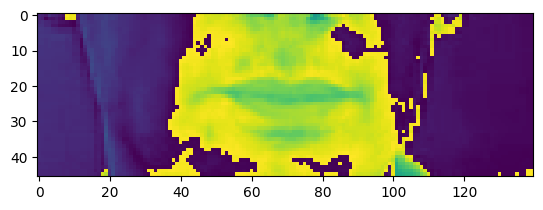

In [24]:
# plt.imshow(frames[4]) # frames of video (0 ~ 74)

In [25]:
# alignments #[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']를 char_to_num을 이용해 숫자로 변환 한 형태

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([12,  1, 25, 39, 18,  5,  4, 39, 19, 16, 39, 23,  9, 20,  8, 39, 12,
       39,  6,  9, 22,  5, 39, 19, 15, 15, 14])>

In [26]:
# alignments.numpy()

array([12,  1, 25, 39, 18,  5,  4, 39, 19, 16, 39, 23,  9, 20,  8, 39, 12,
       39,  6,  9, 22,  5, 39, 19, 15, 15, 14])

In [27]:
# num_to_char(alignments.numpy())

<tf.Tensor: shape=(27,), dtype=string, numpy=
array([b'l', b'a', b'y', b' ', b'r', b'e', b'd', b' ', b's', b'p', b' ',
       b'w', b'i', b't', b'h', b' ', b'l', b' ', b'f', b'i', b'v', b'e',
       b' ', b's', b'o', b'o', b'n'], dtype=object)>

In [28]:
# num_to_char(alignments.numpy()).numpy()

array([b'l', b'a', b'y', b' ', b'r', b'e', b'd', b' ', b's', b'p', b' ',
       b'w', b'i', b't', b'h', b' ', b'l', b' ', b'f', b'i', b'v', b'e',
       b' ', b's', b'o', b'o', b'n'], dtype=object)

In [29]:
# [bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]

['l',
 'a',
 'y',
 ' ',
 'r',
 'e',
 'd',
 ' ',
 's',
 'p',
 ' ',
 'w',
 'i',
 't',
 'h',
 ' ',
 'l',
 ' ',
 'f',
 'i',
 'v',
 'e',
 ' ',
 's',
 'o',
 'o',
 'n']

In [30]:
# tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red sp with l five soon'>

In [17]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [32]:
# 하위 폴더를 돌며 '._' 로 시작하는 파일 지우기
# import os

# def remove_dotunderscore_files(root_folder):
#     for foldername, subfolders, filenames in os.walk(root_folder):
#         for filename in filenames:
#             if filename.startswith('._'):
#                 file_path = os.path.join(foldername, filename)
#                 os.remove(file_path)
#                 print(f'Removed: {file_path}')

# # 사용 예시
# root_directory = './data'
# remove_dotunderscore_files(root_directory)


In [18]:
from matplotlib import pyplot as plt

In [19]:
import os

# 기본 디렉토리 경로
base_dir = './data/150/'

# 서브 디렉토리 목록 (s1부터 s10까지)
# s8의 데이터는 문제가 많아서 제외
sub_directories = [
    # 's2_'
    # 's1', 's2',
    's1_', 's2_', 's3_', 's4_', 's5_', 's6_', 's7_', 's9_', 's10_', 's11_',
    # 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20',
    # 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30',
    # 's31', 's32', 's33', 's34'
    ]

# 모든 데이터셋을 담을 변수
all_data = tf.data.Dataset.list_files([os.path.join(base_dir, sub_dir, '*.mpg') for sub_dir in sub_directories])
# all_data = all_data.repeat(100) # 데이터 셋을 epoch 만큼 반복 시켜 늘림
print(len(all_data))

# 데이터를 메모리에 미리 로드
# all_data = all_data.cache()


# 데이터셋 확인
# for file_path in all_data:
    # print(file_path.numpy().decode('utf-8'))


1492


In [20]:
data = all_data
data_len = len(data)

batch_size = 1

data = data.shuffle(int(data_len / 10), reshuffle_each_iteration=False) # shuffle for 10 %
data = data.map(mappable_function) # load_data -> load_video/load_align 를 거쳐 입모양 부분만 뽑아낸 데이터들이 된다
data = data.padded_batch(batch_size, padded_shapes=([75,None,None,None],[40])) # batch_size 개씩 묶어 배치를 구성. 전체 데이터의 수가 1000 / 2 = 500 이 된다. [40]: .align파일의 마지막 열에 있는 단어와 철자들의 합은 40이하이면 되고 모자란 경우 0으로 패딩된다
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split
train_num = int(data_len / batch_size * 0.8)
train = data.take(train_num)
test = data.skip(train_num)


In [21]:
# frames, alignments = data.as_numpy_iterator().next()

In [22]:
len(train)

1193

In [23]:
len(test)

299

In [24]:
# print("Frames Shape:", frames.shape)
# print("Alignments Shape:", alignments.shape)

# 만약 값이 너무 크다면, 첫 번째 프레임과 정렬 정보의 일부를 출력해 보세요.
# print("First Frame:", frames[0])
# print("First Alignment:", alignments[0])


NameError: name 'frames' is not defined

In [25]:
# len(frames)

NameError: name 'frames' is not defined

In [96]:
# len(alignments)

27

In [97]:
# sample = data.as_numpy_iterator()

In [98]:
# val = sample.next(); val[0]

array([[[[[1.2006118 ],
          [1.2006118 ],
          [1.2006118 ],
          ...,
          [9.417298  ],
          [9.417298  ],
          [9.454818  ]],

         [[1.2006118 ],
          [1.2006118 ],
          [1.2006118 ],
          ...,
          [9.417298  ],
          [9.417298  ],
          [9.454818  ]],

         [[1.1630927 ],
          [1.1630927 ],
          [1.1630927 ],
          ...,
          [9.492337  ],
          [9.529856  ],
          [9.529856  ]],

         ...,

         [[0.6003059 ],
          [0.6003059 ],
          [0.6003059 ],
          ...,
          [8.479321  ],
          [8.51684   ],
          [8.554359  ]],

         [[0.6003059 ],
          [0.6003059 ],
          [0.6003059 ],
          ...,
          [8.479321  ],
          [8.51684   ],
          [8.591878  ]],

         [[0.6003059 ],
          [0.6003059 ],
          [0.6003059 ],
          ...,
          [8.51684   ],
          [8.591878  ],
          [8.704435  ]]],


        [[[1.1255

In [99]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)
# imageio.mimsave('./animation.gif', val[0][0].squeeze(), fps=10)

In [100]:
# 0:videos(1:alignments), 0: 1st video out of the batch(0~1),  0: return the first frame in the video(0~74)
# plt.imshow(val[0][0][12])

In [101]:
# tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])
# ([num_to_char(word) for word in val[1][0]])

In [102]:
# ([(word) for word in val[1][0]]) #마지막에 0의 연속이 들어간 것은 패딩의 효과 인듯

# 3. Design the Deep Neural Network

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
# from tensorflow.keras.optimizers import Adam #`tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [38]:
# data.as_numpy_iterator().next()[0][0].shape #[0: video][0: 배치 중 1번째]

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [41]:
# 5*17*75

In [42]:
# yhat = model.predict(val[0])

In [109]:
# tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [110]:
# tf.argmax(yhat[0], axis=1)

In [111]:
# tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [30]:
model.input_shape

(None, 75, 46, 140, 1)

In [31]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTCLoss(y_true, y_pred):

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [45]:
class ProduceExample(tf.keras.callbacks.Callback):

    def __init__(self, dataset_) -> None:
        self.dataset = dataset_
        print(self.dataset)
        self.iterator = self.dataset.as_numpy_iterator()


    def on_epoch_end(self, epoch, logs=None) -> None:
        try:
            data = self.iterator.next()
        except StopIteration:
            self.iterator = self.dataset.as_numpy_iterator()
            data = self.iterator.next()

        yhat = self.model.predict(data[0])
        print("yhat------------")
        print(yhat.shape)
        print(yhat[0][0])
        print(yhat.shape[0])
        print(yhat)

        batch_size_ = yhat.shape[0]
        print(batch_size_)
        print(f'len yhat: {len(yhat)}')

        decoded = tf.keras.backend.ctc_decode(yhat, [75] * batch_size_, greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join(BASE_PATH + 'models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

<_SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>


In [118]:
# spe = int(data_len / batch_size)
# print("steps_per_epoch: " + str(spe))

In [119]:
# 트레이스백 필터링 비활성화
tf.debugging.disable_traceback_filtering()

In [120]:
# pip install torch

In [121]:
# import tensorflow as tf

# print("TensorFlow version:", tf.__version__)
# print("CUDA version:", tf.test.is_built_with_cuda())
# # print("cuDNN version:", tf.test.is_built_with_cudnn())
# print("cuDNN version:", tf.config.list_physical_devices('GPU'))


import torch
print("cudnn version:{}".format(torch.backends.cudnn.version()))
print("cuda version: {}".format(torch.version.cuda))

cudnn version:8901
cuda version: 12.1


In [122]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
1/1 [==============================] - 1s 901ms/step - loss: 78.80
yhat------------
(1, 75, 41)
[0.00614552 0.03378477 0.13781337 0.00551973 0.00367048 0.0294256
 0.00289672 0.00574014 0.00363985 0.02751667 0.00214086 0.00205911
 0.26640752 0.00211815 0.01047057 0.00279005 0.17981973 0.00339729
 0.00683529 0.16945863 0.01749746 0.00357504 0.00193665 0.00508477
 0.00225753 0.01007132 0.00215888 0.00082062 0.00100834 0.0010231
 0.00211802 0.00155704 0.00054392 0.00113166 0.00109391 0.00141836
 0.0017674  0.00072449 0.002151   0.00998338 0.03042704]
1
[[[6.1455159e-03 3.3784766e-02 1.3781337e-01 ... 2.1510031e-03
   9.9833841e-03 3.0427042e-02]
  [4.1881795e-03 1.8931794e-01 6.2452327e-02 ... 1.2980463e-03
   2.0527365e-02 3.1474460e-02]
  [3.2406920e-03 2.6545128e-01 2.8476775e-02 ... 1.0412335e-03
   6.5334164e-02 2.6527349e-02]
  ...
  [4.8103160e-01 2.6657654e-04 3.3560253e-05 ... 4.4745957e-05
   5.7159225e-05 5.1582557e-01]
  [3.1484413e-01 3.3291033e-04 4.1059495e-05 ...

2024-01-20 03:08:12.246438: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.
2024-01-20 03:08:12.249995: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/
Traceback (most recent call last):

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [22,1] [Op:Reshape]
Traceback (most recent call last):

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_364371/3595898013.py", line 18, in load_data
    frames = load_video(video_path)
             ^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_364371/1668792994.py", line 13, in load_video
    frame = tf.image.rgb_to_grayscale(frame)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [22,1] [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_48]]
  (1) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [22,1] [Op:Reshape]
Traceback (most recent call last):

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_364371/3595898013.py", line 18, in load_data
    frames = load_video(video_path)
             ^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_364371/1668792994.py", line 13, in load_video
    frame = tf.image.rgb_to_grayscale(frame)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/home/unbarrier/.pyenv/versions/3.11.7/envs/py3.11/lib/python3.11/site-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} sizes input must be 1-D, not [22,1] [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_73612236]

In [ ]:
# 트레이스백 필터링 다시 활성화
tf.debugging.enable_traceback_filtering()

# 5. Make a Prediction

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [47]:
model.load_weights(BASE_PATH + 'models/checkpoint')

In [56]:
test_data = test.as_numpy_iterator()

In [234]:
sample = test_data.next() # 첫 실행시 오래 걸림

In [235]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 27ms/step


In [236]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at q zero please'>]

In [237]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75] * batch_size, greedy=True)[0][0].numpy()

In [238]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at q zero please'>]

# 6. Test on a Video

In [124]:
import os
import random

def get_random_mpg_path(root_folder):
    mpg_files = []
    
    # root_folder와 그 하위 폴더에서 .mpg 파일 찾기
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.mpg'):
                mpg_files.append(os.path.join(foldername, filename))
    
    # .mpg 파일이 없으면 None 반환
    if not mpg_files:
        return None
    
    # 랜덤하게 선택된 .mpg 파일 경로 반환
    return random.choice(mpg_files)

# 사용 예시
root_folder = BASE_PATH + 'data/'
random_mpg_path = get_random_mpg_path(root_folder)

if random_mpg_path:
    print(f'랜덤하게 선택된 .mpg 파일 경로: {random_mpg_path}')
else:
    print('폴더 안에 .mpg 파일이 없습니다.')


랜덤하게 선택된 .mpg 파일 경로: ./data/s30/bgbe8a.mpg


In [257]:
# 1. load random data (from s1 ~ s34, 훈련 데이터에 포함된 것도 있음. s12 부터는 훈련 데이터에 포함되지 않음.)
test_path = get_random_mpg_path(root_folder)
print(test_path)
sample = load_test_data(tf.convert_to_tensor(test_path))
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

./data/s34/pbil2s.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue in l two soon'>]

In [258]:
# 2. predict
yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

1/1 [==============================] - 0s 27ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay gree it u eive sleasn'>]